# Prueba técnica - Data Scientist - CoverWallet

*Santiago Morales Saldarriaga*

Practical test for the process in the Data Scientist Position.
Date: 27/04/2024

In [1]:
import os
import shap

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import bctools as bc
from dython.nominal import identify_nominal_columns
from sklearn.model_selection import RandomizedSearchCV, GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sentence_transformers import SentenceTransformer
from catboost import CatBoostClassifier, CatBoostRegressor


while 'data' not in os.listdir(os.getcwd()):
    os.chdir('..')

/home/smoraless/Documentos/coverwallet/challenge 4/coverwallet/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading The Files

In [2]:
accounts_train = pd.read_csv('data/accounts_train.csv')
accounts_test = pd.read_csv('data/accounts_test.csv')
quotes_train = pd.read_csv('data/quotes_train.csv')
quotes_test = pd.read_csv('data/quotes_test.csv')

In [3]:
train = accounts_train.merge(quotes_train, how='left', on='account_uuid')
test = accounts_test.merge(quotes_test, how='left', on='account_uuid')

In [4]:
gss = GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
split = gss.split(train, groups=train['account_uuid'])
train_inds, val_inds = next(split)

train, val = train.loc[train_inds], train.loc[val_inds]

groups_train, groups_test = train['account_uuid'].unique(), val['account_uuid'].unique()

for account in groups_train:
    assert account not in groups_test

## Preliminar Analysis



In [5]:
train.describe()

year_established  annual_revenue  total_payroll  num_employees  \
count       9359.000000    9.378000e+03   9.339000e+03    9350.000000   
mean        2013.086868    2.907153e+05   4.584850e+04       9.147914   
std           24.550197    2.364920e+06   2.550178e+05     526.604363   
min            6.000000    0.000000e+00   0.000000e+00       0.000000   
25%         2013.000000    3.000000e+04   0.000000e+00       0.000000   
50%         2017.000000    6.500000e+04   0.000000e+00       0.000000   
75%         2017.000000    1.500000e+05   3.000000e+04       1.000000   
max         2107.000000    7.500000e+07   7.000000e+06   36000.000000   

            premium   carrier_id      convert  
count   9418.000000  9418.000000  9418.000000  
mean    1456.153237    40.574113     0.580059  
std     2865.604376    15.197160     0.493575  
min        1.000000     1.000000     0.000000  
25%      500.000000    31.000000     0.000000  
50%      619.675000    39.000000     1.000000  
75%     1248.000000    56.000000     1.000000  
max    75508.000000    77.000000     1.000000

In [6]:
train['years_in_business'] = 2024 - train['year_established']
train = train.drop('year_established', axis=1)

val['years_in_business'] = 2024 - val['year_established']
val = val.drop('year_established', axis=1)

test['years_in_business'] = 2024 - test['year_established']
test = test.drop('year_established', axis=1)

In [7]:
pd.DataFrame(train.isna().sum()).T

account_uuid  state  industry  subindustry  annual_revenue  total_payroll  \
0             0     36       191          191              40             79   

   business_structure  num_employees  product  premium  carrier_id  convert  \
0                   1             68        0        0           0        0   

   years_in_business  
0                 59

There are missing values for the state, industry, subindustry, annual_revenue, total_payroll, business_structure, num_employees and years_in_business (year_established).

- *state, industry, subindustry, business_structure*: These are all categorical parameters. There is a chance that notanswering these questions in the form give us some valuable information, so I fill the nan values with a new category 'nan' that the model will handle as a different category.
- *annual_revenue, total_payroll, num_employees and years_in_business*: These are numerical variables, so there is no a direct answer of how to handle. One possible solution (and what I am going to do) is using a model that, intrinsically, manage the nan values. In this case I'll use a tree-based model so, for the model, is as simple as include missing values in the tree decision nodes.

### Cleaning Categorical Values

In [8]:
nominal_columns = identify_nominal_columns(train)
nominal_columns.remove('account_uuid')

for col in nominal_columns:
    train[col] = train[col].fillna('nan')
    val[col] = val[col].fillna('nan')
    test[col] = test[col].fillna('nan')

In [9]:
train['state'].value_counts().sort_values(ascending=False)[-10::]

state
NE                   20
ND                   14
VT                   13
SD                    5
HI                    2
California            1
PA - Pennsylvania     1
Washington DC         1
AK                    1
Florida               1
Name: count, dtype: int64

In [10]:
test['state'].value_counts().sort_values(ascending=False)[-10::]

state
NE     11
ME     10
IA     10
MT      9
VT      9
AK      6
SD      3
nan     3
ND      2
HI      2
Name: count, dtype: int64

In [11]:
train['state'] = train['state'].replace({
    'New York': 'NY',
    'California': 'CA', 
    'PA - Pennsylvania': 'PA',
    'Washington DC': 'DC',
    'Oregon': 'OR',
    'Florida': 'FL',
})
print(f'Number of Unique values for state column: {train["state"].nunique()}')

Number of Unique values for state column: 52


In [12]:
train['industry'].value_counts().sort_values(ascending=False)

industry
Retail Trade                                        1586
Contractors                                         1579
Other Services                                      1278
Professional, Scientific and Technical Services      859
Administrative Services and Building Maintenance     728
Food and Accommodation                               613
Consultants                                          407
Technology, Media and Telecommunications             358
Manufacturing                                        275
Healthcare                                           250
Wholesale Trade                                      228
Transportation and Warehousing                       218
Real Estate                                          196
nan                                                  191
Sports, Arts, Entertainment, and Recreation          162
Construction                                         150
Finance and Insurance                                131
Education             

In [13]:
print(f'Different values in subindustry: {train["subindustry"].nunique()}')

Different values in subindustry: 447


### Extracting Extra Subindustry information

I've decided to use a language model like BERT to encode the subindustry information due to the complexity and variability inherent in this feature, which often consists of numerous distinct values. BERT, being a robust contextual language model, is adept at capturing the intricate semantic relationships and contextual nuances within subindustry labels. Its proficiency in understanding natural language text in context enables it to generate dense, meaningful representations of the subindustry information. This approach offers several benefits, such as the capability to handle a diverse range of subindustry values without the need for manual feature engineering or dimensionality reduction techniques. Furthermore, by encoding subindustry information with BERT, the resulting representations seamlessly integrate into downstream machine learning models, facilitating more accurate predictions and insights while preserving the richness of the original subindustry data.


In [14]:
# Load pre-trained BERT model for sentence embeddings
sentence_model = SentenceTransformer('bert-base-nli-mean-tokens', truncate_dim=5)

# Encode text data using BERT
encoded_data_train = sentence_model.encode(train.loc[~train['subindustry'].isna(), 'subindustry'].values, show_progress_bar=True)
encoded_data_val = sentence_model.encode(val.loc[~val['subindustry'].isna(), 'subindustry'].values, show_progress_bar=True)
encoded_data_test = sentence_model.encode(test.loc[~test['subindustry'].isna(), 'subindustry'].values, show_progress_bar=True)

/home/smoraless/Documentos/coverwallet/challenge 4/coverwallet/lib/python3.9/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Batches: 100%|██████████| 157/157 [00:41<00:00,  3.75it/s]


In [15]:
train[[f'subindustry_enc_{i}' for i in range(5)]] = 0., 0., 0., 0., 0.
train.loc[~train['subindustry'].isna(), [f'subindustry_enc_{i}' for i in range(5)]] = encoded_data_train

test[[f'subindustry_enc_{i}' for i in range(5)]] = 0., 0., 0., 0., 0.
test.loc[~test['subindustry'].isna(), [f'subindustry_enc_{i}' for i in range(5)]] = encoded_data_test

val[[f'subindustry_enc_{i}' for i in range(5)]] = 0., 0., 0., 0., 0.
val.loc[~val['subindustry'].isna(), [f'subindustry_enc_{i}' for i in range(5)]] = encoded_data_val

### Observation of the distributions:

To gain a better understanding of the variable distributions, let's plotted the distribution of continuous variables based on whether the there is a conversion or not. This will provide us with a preliminary idea of which variables might be more important for the model.

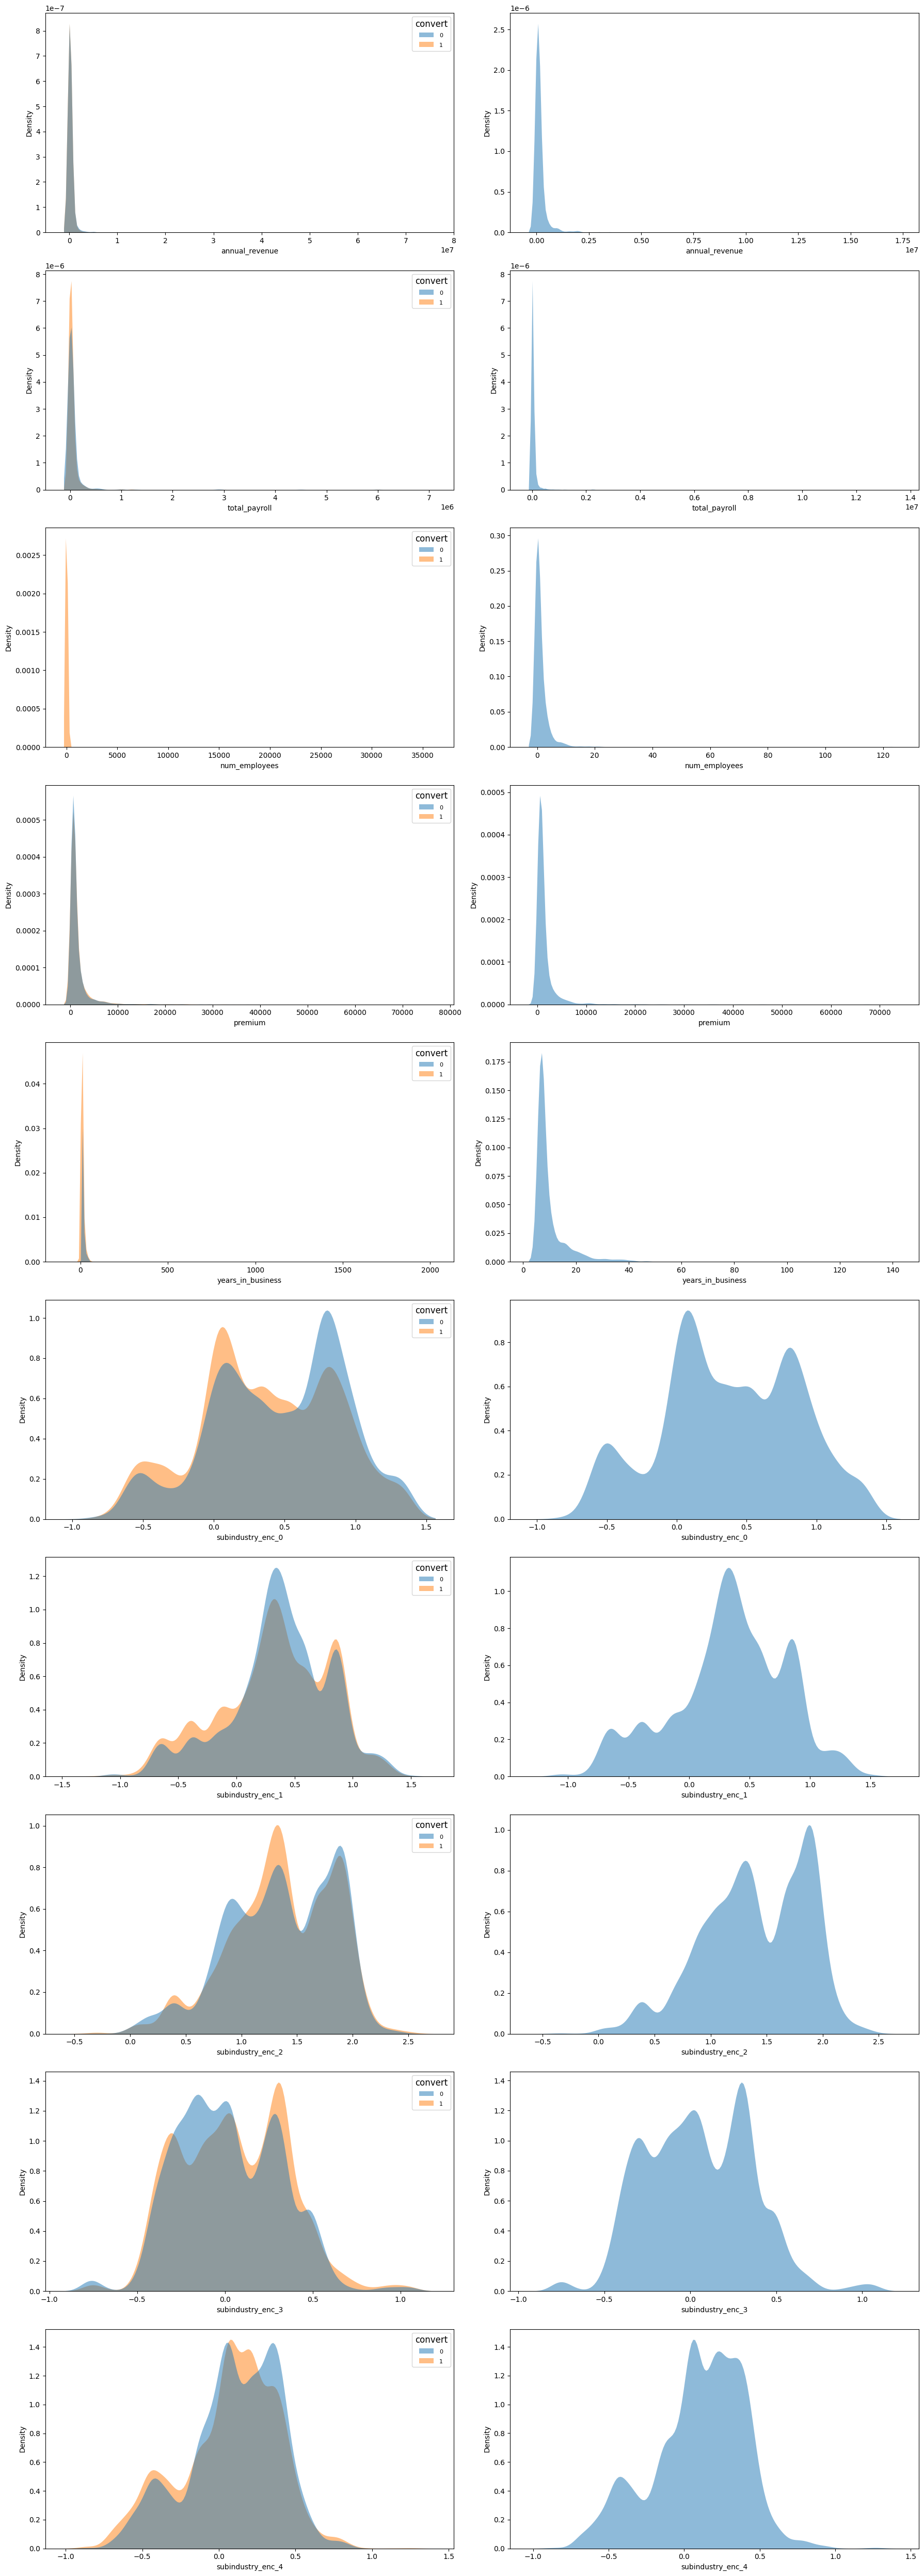

In [16]:
cont_cols = ['annual_revenue', 'total_payroll', 'num_employees', 'premium', 'years_in_business', 'subindustry_enc_0',
             'subindustry_enc_1', 'subindustry_enc_2', 'subindustry_enc_3', 'subindustry_enc_4']

num_rows = 10
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 50))
for i, column in enumerate(cont_cols):
    ax = axes[i][0]
    sns.kdeplot(
        data=train, 
        x=column, 
        hue='convert',
        fill=True, 
        common_norm=False,
        common_grid=True,
        alpha=.5,
        ax=ax,
        linewidth=0,
    )
    
    plt.setp(ax.get_legend().get_texts(), fontsize='8')
    plt.setp(ax.get_legend().get_title(), fontsize='12')

for i, column in enumerate(cont_cols):
    ax = axes[i][1]
    sns.kdeplot(
        data=test, 
        x=column, 
        fill=True, 
        common_norm=False,
        common_grid=True,
        alpha=.5,
        ax=ax,
        linewidth=0,
    )

plt.tight_layout()
plt.show()

There are some values that are, clearly, big outliers in the training set. The best for the model is to remove those values in order to not bias the model.

In [17]:
print(f'% of train samples of companies with annual revenue > 5e6: {len(train.loc[train["annual_revenue"] > 1.5e7]) / len(train) * 100:1.2f}%')
print(f'% of train samples of companies with number of employees > 500: {len(train.loc[train["num_employees"] > 500]) / len(train) * 100:1.2f}%')
print(f'% of train samples of companies older than 400 years: {len(train.loc[train["years_in_business"] > 400]) / len(train) * 100:1.2f}%')
print(f'% of train samples of offers with premium > 20000: {len(train.loc[train["premium"] > 20000]) / len(train) * 100:1.2f}%')

% of train samples of companies with annual revenue > 5e6: 0.21%
% of train samples of companies with number of employees > 500: 0.03%
% of train samples of companies older than 400 years: 0.02%
% of train samples of offers with premium > 20000: 0.52%


In [18]:
train = train.loc[train["annual_revenue"] < 5e6]
train = train.loc[train["num_employees"] < 500]
train = train.loc[train["premium"] < 20000]
train = train.loc[train["years_in_business"] < 400]

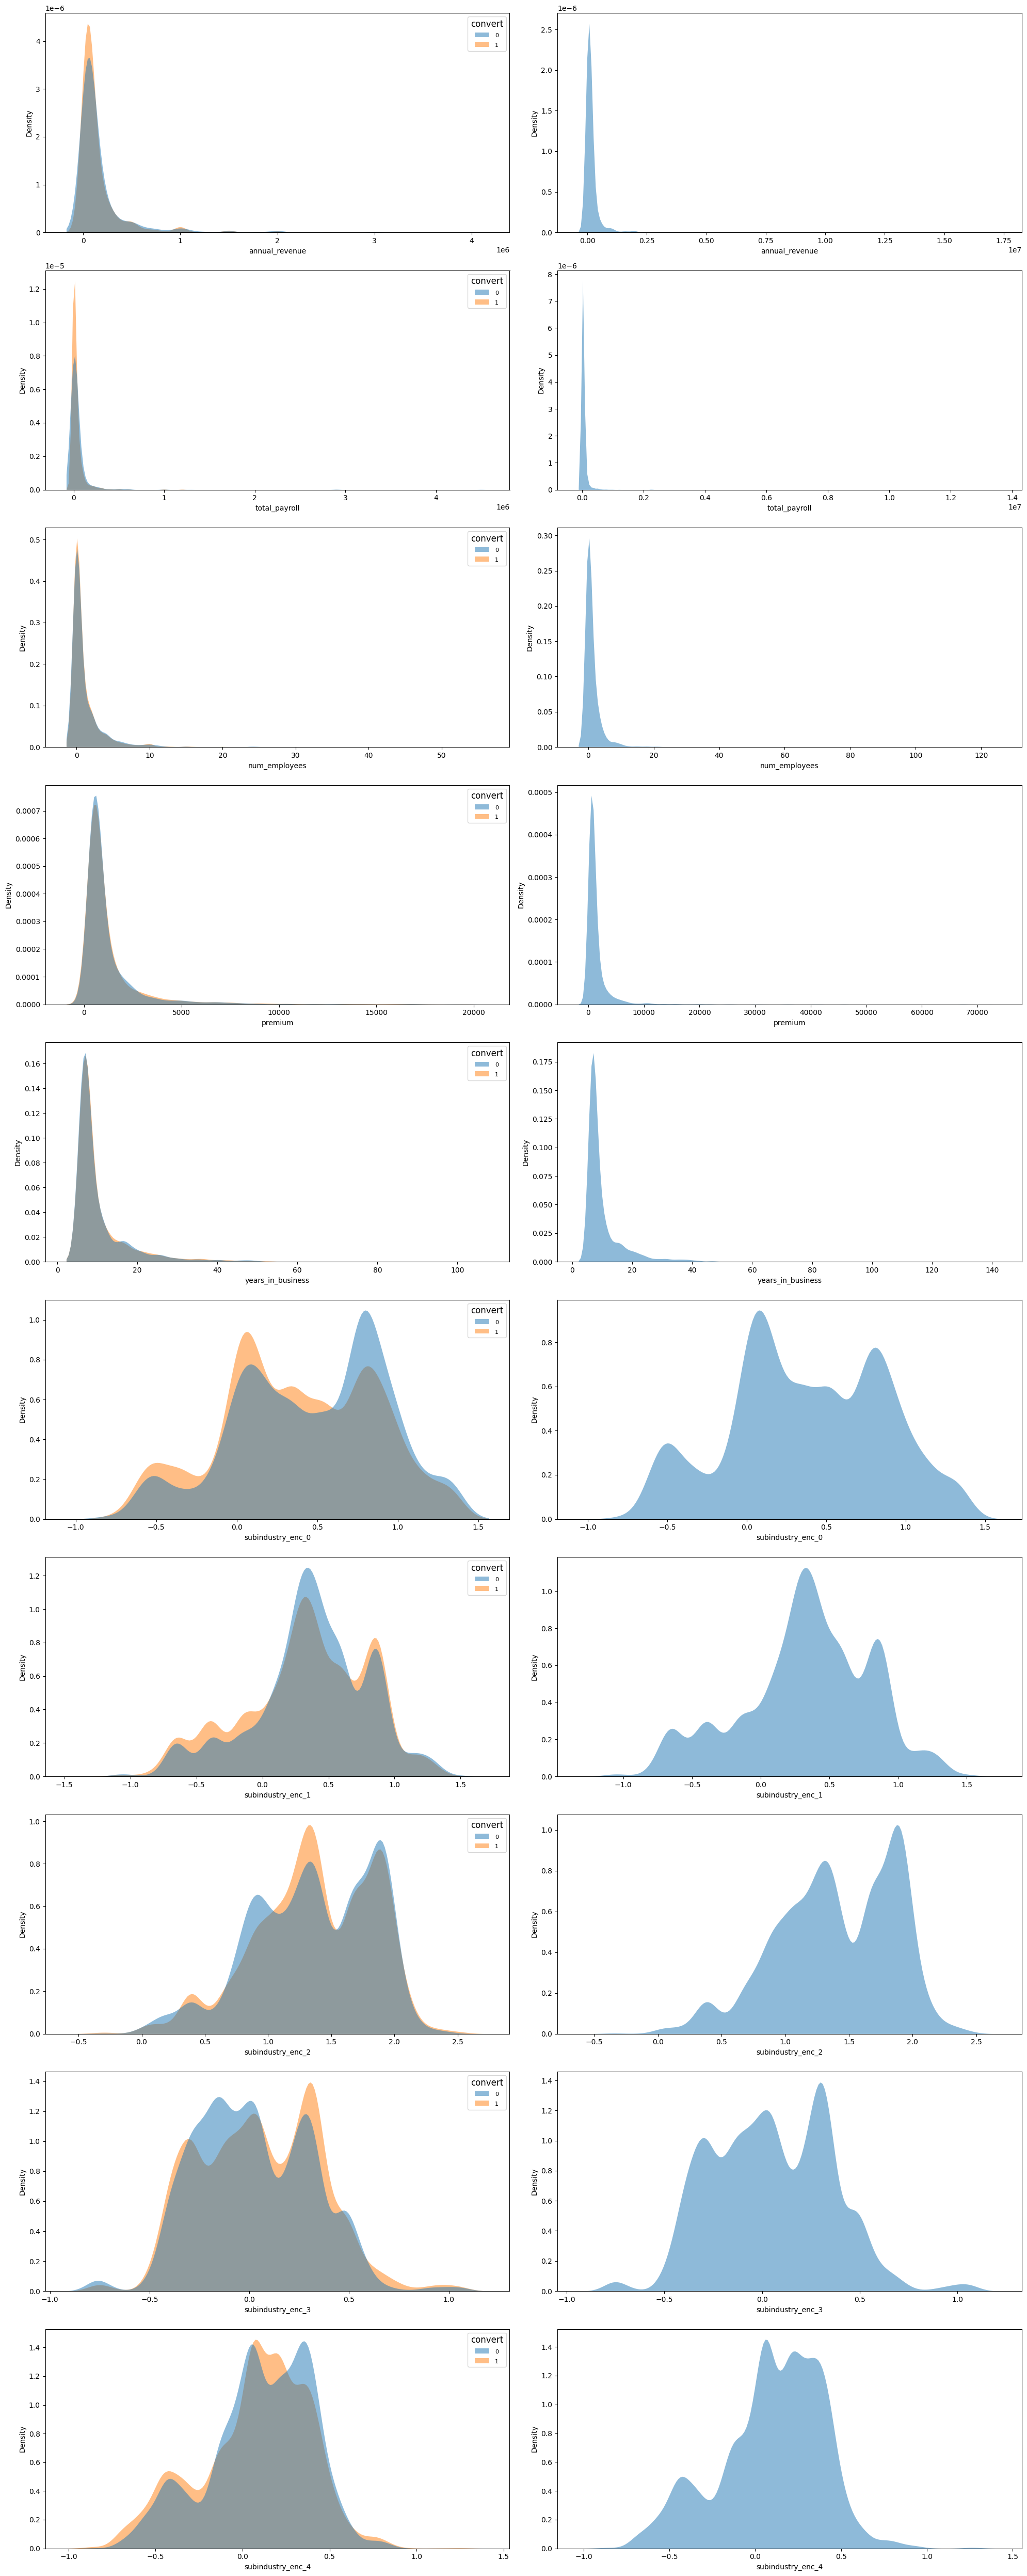

In [19]:
cont_cols = ['annual_revenue', 'total_payroll', 'num_employees', 'premium', 'years_in_business', 'subindustry_enc_0',
             'subindustry_enc_1', 'subindustry_enc_2', 'subindustry_enc_3', 'subindustry_enc_4']

num_rows = 10
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 50))
for i, column in enumerate(cont_cols):
    ax = axes[i][0]
    sns.kdeplot(
        data=train, 
        x=column, 
        hue='convert',
        fill=True, 
        common_norm=False,
        common_grid=True,
        alpha=.5,
        ax=ax,
        linewidth=0,
    )
    
    plt.setp(ax.get_legend().get_texts(), fontsize='8')
    plt.setp(ax.get_legend().get_title(), fontsize='12')

for i, column in enumerate(cont_cols):
    ax = axes[i][1]
    sns.kdeplot(
        data=test, 
        x=column, 
        fill=True, 
        common_norm=False,
        common_grid=True,
        alpha=.5,
        ax=ax,
        linewidth=0,
    )

plt.tight_layout()
plt.show()

At first glance, we observe fairly similar distributions, suggesting that classification may pose a challenge for the model. However, we can still discern some details that provide valuable insights:

- Perhaps the "clearest" difference is evident in the premium variable, where the distribution of values associated with no conversion appears slightly shifted to the right at lower values.

Let's now examine the difference among the categorical variables distributions:

/tmp/ipykernel_154816/1319573315.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_154816/1319573315.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_154816/1319573315.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_154816/1319573315.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


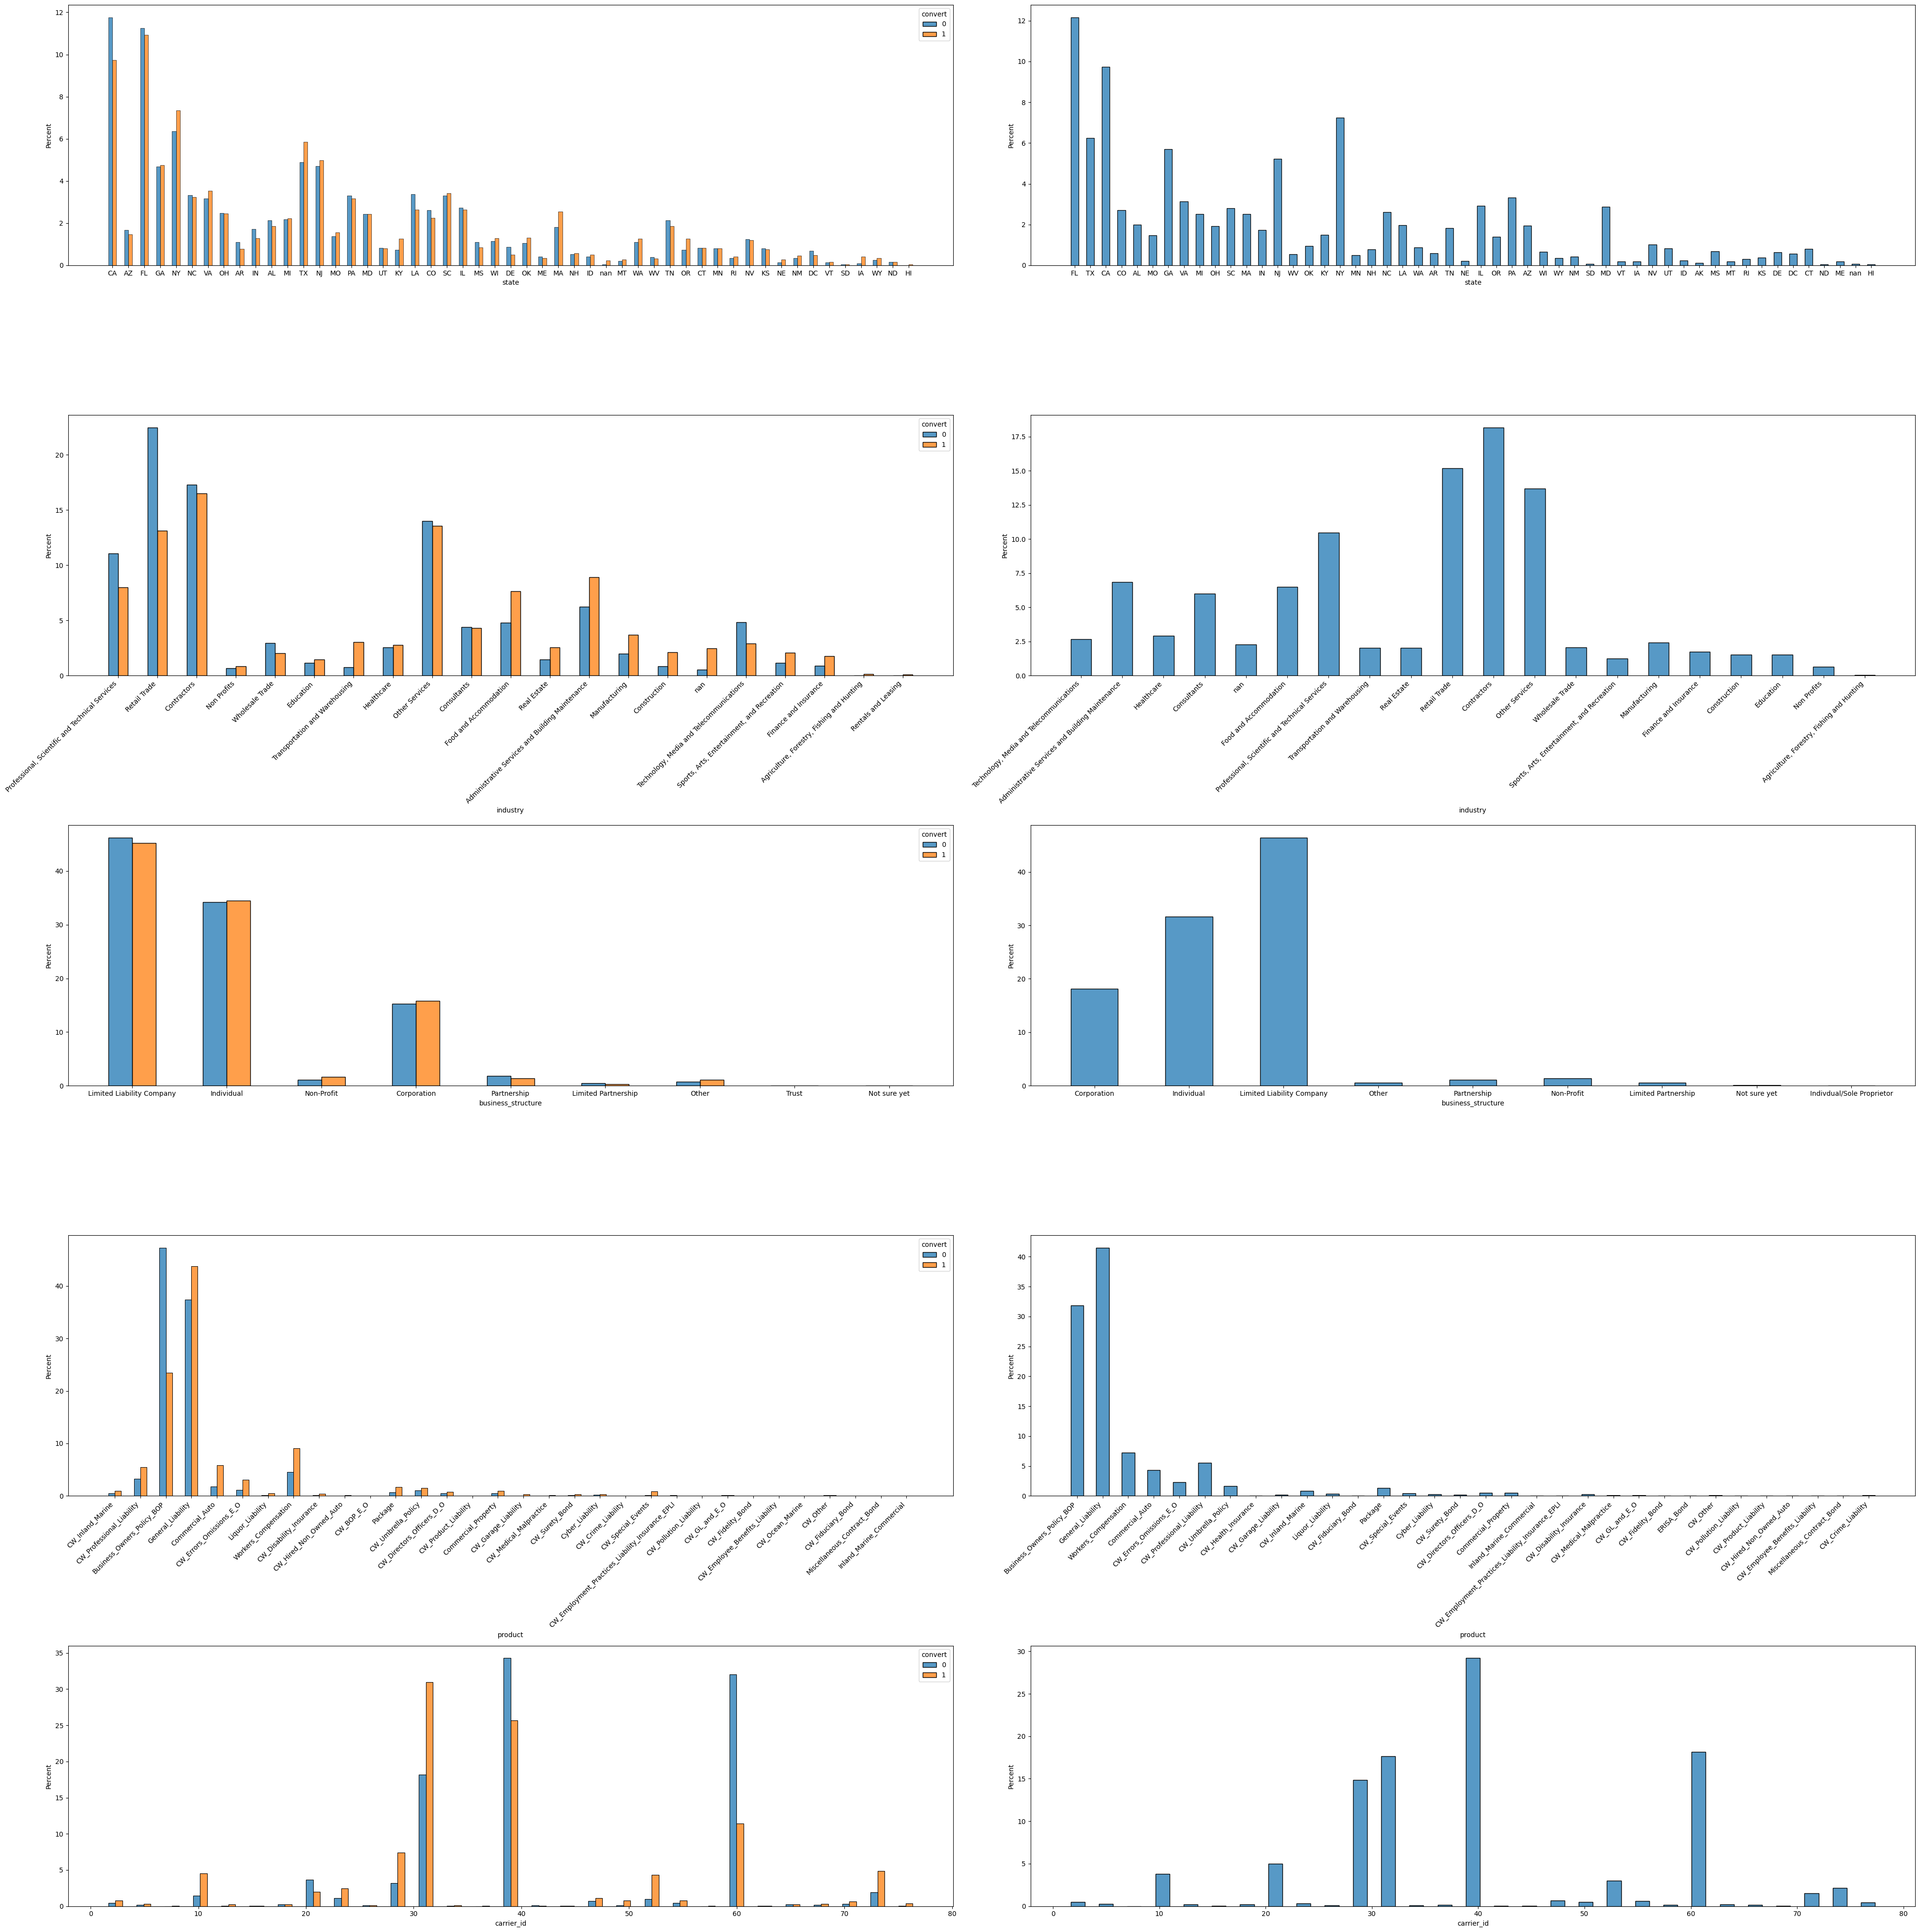

In [20]:
cat_cols = ['state', 'industry', 'business_structure', 'product', 'carrier_id']


num_rows = 5
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(40, 40))

for i, column in enumerate(cat_cols):
    ax = axes[i][0]
    sns.histplot(
        train,
        x=column, 
        hue='convert', 
        multiple="dodge",
        stat='percent', 
        shrink=0.5, 
        common_norm=False,
        ax=ax)
    if column in ['industry', 'product']:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for i, column in enumerate(cat_cols):
    ax = axes[i][1]
    sns.histplot(
        test,
        x=column,
        multiple="dodge",
        stat='percent', 
        shrink=0.5, 
        common_norm=False,
        ax=ax)
    if column in ['industry', 'product']:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In this instance, we observe significant differences in certain variables:

- Regarding the product, there are clear disparities in conversion rates; for instance, General Liability exhibits a much higher conversion ratio compared to BOP.
- In terms of industry, again, we find instances where the conversion ratio varies significantly across different values. For example, Retail trade displays a considerably lower conversion ratio compared to Food Accommodation or Building Maintenance.
- Similarly, with the state variable, there are states where the conversion ratio notably increases or decreases relative to others.
- Conversely, it appears that business structure does not have a significant impact, as the distributions are quite similar.

## Model Analysis

Let's examine some model metrics to determine if it can accurately identify conversions. For this, we'll utilize the validation dataset, which the model has not encountered at any point:

In [21]:
X_train = train.loc[:, [col for col in train.columns if col not in ['account_uuid', 'convert']]]
y_train = train.loc[:, 'convert']

X_val = val.loc[:, [col for col in train.columns if col not in ['account_uuid', 'convert']]]
y_val = val.loc[:, 'convert']

X_test = test.loc[:, [col for col in train.columns if col not in ['account_uuid', 'convert']]]

In [22]:
print(f'The {y_train.mean() * 100:1.1f}% of the data are conversions.')

The 57.9% of the data are conversions.


Given the dataset's moderate balance, it's plausible that model calibration may not be necessary.

### Model Training

In this section, we delve into the training process of our model, focusing on hyperparameter optimization using RandomizedSearchCV. The goal is to fine-tune the model's parameters to enhance its predictive performance. Additionally, we enforce a crucial constraint: ensuring the model's output remains monotonically decreasing with respect to the premium variable (price). This decision is grounded in logic, as it aligns with the economic principle that, for individuals with similar characteristics, the probability of purchasing a product decreases monotonically with its price—a concept commonly illustrated by the elasticity curve. By imposing this constraint, we aim to capture this fundamental relationship accurately within our model.

In [23]:
iterations =            np.unique(np.geomspace(100, 1000, num=10, dtype=np.int32)).tolist() 
depth =                 np.unique(np.geomspace(3, 10, num=10, dtype=np.int32)).tolist()
learning_rate =         np.unique(np.around(np.geomspace(1e-3, 0.1, num=10), decimals=3)).tolist()
l2_leaf_reg =           np.unique(np.around(np.geomspace(1e-8, 100, num=10), decimals=3)).tolist()
random_strength =       np.unique(np.around(np.geomspace(10, 20, num=10), decimals=3)).tolist()
bagging_temperature =   np.unique(np.around(np.geomspace(1, 20, num=10), decimals=3)).tolist()

cat_cols = identify_nominal_columns(X_train)

# Define the parameter grid
param_grid = {
    'iterations': iterations,
    'depth': depth,
    'learning_rate': learning_rate,
    'l2_leaf_reg': l2_leaf_reg,
    'random_strength': random_strength,
    'bagging_temperature': bagging_temperature,
}

# Initialize CatBoostClassifier
monotone_constraints = {'premium': -1}
cb = CatBoostClassifier(cat_features=cat_cols, 
                        monotone_constraints=monotone_constraints,
                        verbose=False)

# Initialize GridSearchCV
grid = RandomizedSearchCV(estimator=cb, 
                          param_distributions=param_grid,
                          n_iter=10,
                          scoring='f1')

# Fit data
grid.fit(X_train, y_train)

# Get the best parameters
best_params = grid.best_params_
print(f"Best parameters: {best_params}")

Best parameters: {'random_strength': 10.0, 'learning_rate': 0.005, 'l2_leaf_reg': 7.743, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 1.946}


In [24]:
print(grid.best_params_)
model_cls = grid.best_estimator_

{'random_strength': 10.0, 'learning_rate': 0.005, 'l2_leaf_reg': 7.743, 'iterations': 1000, 'depth': 4, 'bagging_temperature': 1.946}


In [25]:
val_predicted_proba = model_cls.predict_proba(X_val)
val_predicted_proba = [predicted_proba[1] for predicted_proba in val_predicted_proba]

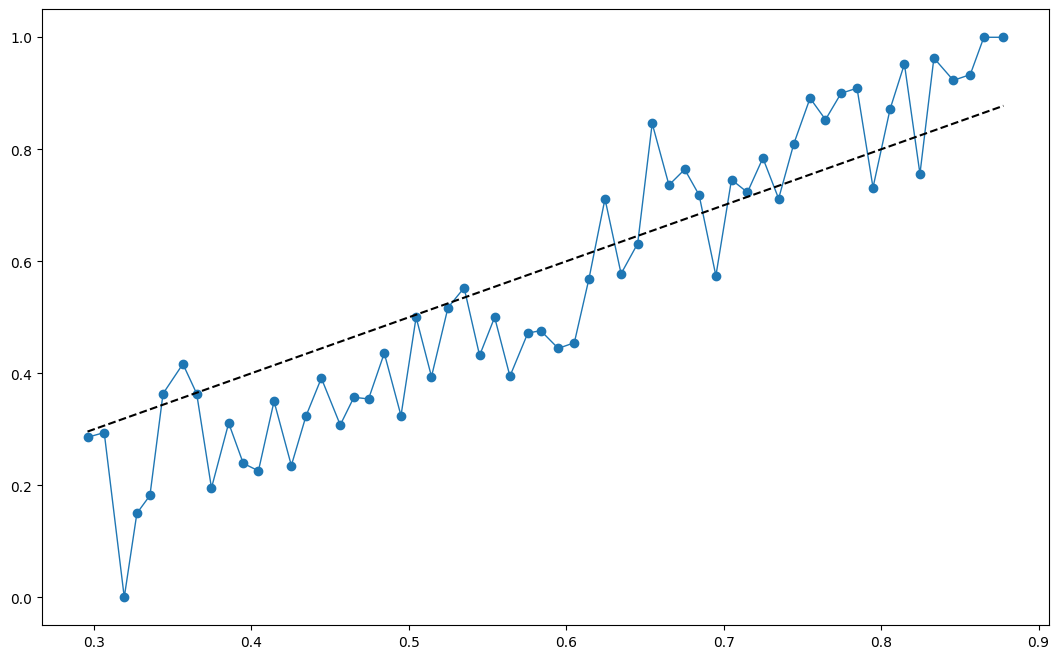

In [26]:
from sklearn.calibration import calibration_curve

n_bins=100
true_pos, pred_pos = calibration_curve(y_val.values, val_predicted_proba, n_bins=n_bins)
 
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(pred_pos,
        true_pos, 
        marker='o', 
        linewidth=1,)
ax.plot(pred_pos, pred_pos, '--', color='k')

We observe that the model is indeed callibrated, allowing us to treat the model output as a realistic probability of conversion.

In [27]:
ROC_plot, area_under_ROC = bc.curve_ROC_plot(true_y = y_val.values, 
                                             predicted_proba = val_predicted_proba)
print(f"AUC: {area_under_ROC}")
ROC_plot.show()

AUC: 0.7434018330341003


In [28]:
PR_plot, area_under_PR = bc.curve_PR_plot(true_y = y_val.values, 
                                          predicted_proba = val_predicted_proba)
print(f"AUC: {area_under_PR}")
PR_plot.show()

AUC: 0.7882011466587728


The ROC and the PR curves demonstrate that the model is indeed extracting crucial information from the parameters, as it significantly improves upon the baseline.

In [29]:
threshold_step = 0.025
curve_type = 'kde'

density_curve_kde = bc.predicted_proba_density_curve_plot(true_y = y_val.values, 
                                                          predicted_proba = val_predicted_proba, 
                                                          threshold_step = threshold_step,
                                                          curve_type = curve_type)
density_curve_kde.show()

In [30]:
cf_fig, var_metrics_df, invar_metrics_df, opt_thresh_df = bc.confusion_matrix_plot(
    true_y = y_val, 
    predicted_proba = val_predicted_proba, 
    threshold_step = threshold_step, 
    title = 'Interactive Confusion Matrix for the Validation Set')
cf_fig

Obtaining a value of F1-Score of ~0.74 when 0.6 is used as threshold

In [31]:
print(f'F1-Score of the model: {model_cls.get_best_score()}')

F1-Score of the model: {'learn': {'Logloss': 0.5882644130393668}}


In the previous section, we can observe that the model effectively distinguishes between the distributions of offers that result in conversions and those that do not.

Using this intermediate information we could calculate the account value using the expected value.

#### Feature Importance

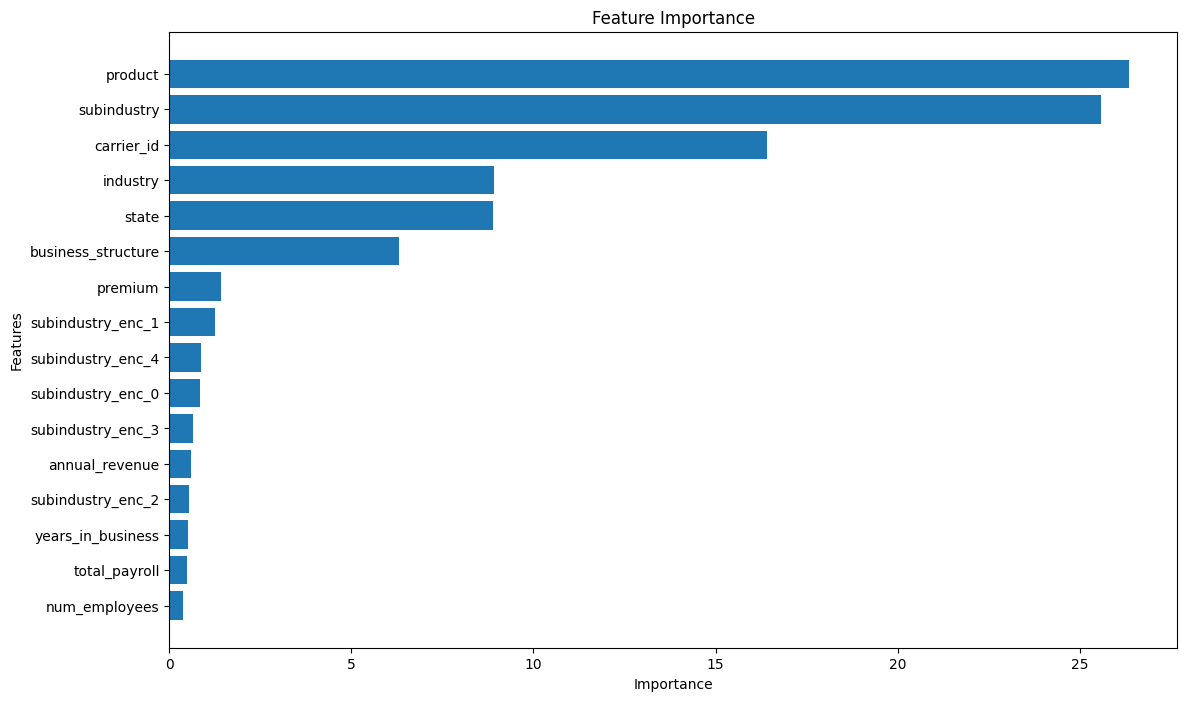

In [32]:
importances = model_cls.get_feature_importance(type='PredictionValuesChange')
feature_importances = pd.Series(importances, index=X_train.columns).sort_values()
fix, ax = plt.subplots(figsize=(13, 8))
ax.barh(feature_importances.index, feature_importances.values)
ax.set_title('Feature Importance')
ax.set_xlabel('Importance')
ax.set_ylabel('Features')
plt.show()

Here, we observed that the categorical variables are more crucial for the model, as previously noted by examining the distribution differences.

Additionally, we noticed that the majority of the variance information resides in the product, subindustry, carrier, state, and industry variables.

In [33]:
explainer = shap.TreeExplainer(model_cls)
shap_values = explainer(X_val, y_val)

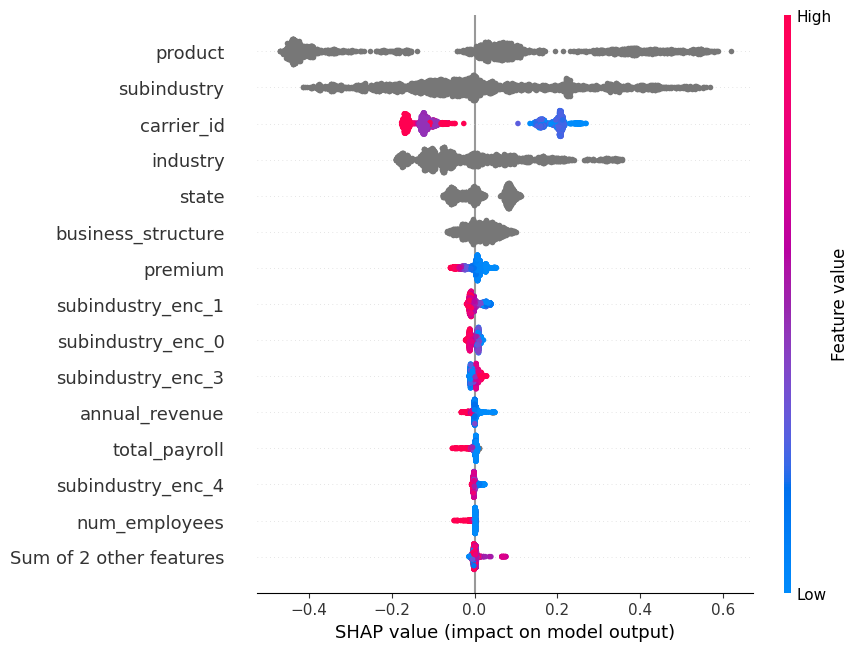

In [34]:
shap.plots.beeswarm(shap_values, max_display=15)

Here, we can confirm what we observed in the feature importance plot. Additionally, we discovered some peculiar information regarding the carriers. We noticed that carriers with lower carrier IDs have a higher probability of conversion. This phenomenon could be attributed to the principal carriers having the lowest IDs.

Moreover, we observed that imposing the restriction of premium to be monotonically decreasing makes sense for the model, as it is capturing the relationship accurately. Similarly, it appears there is a comparable relationship with total payroll and annual revenue.

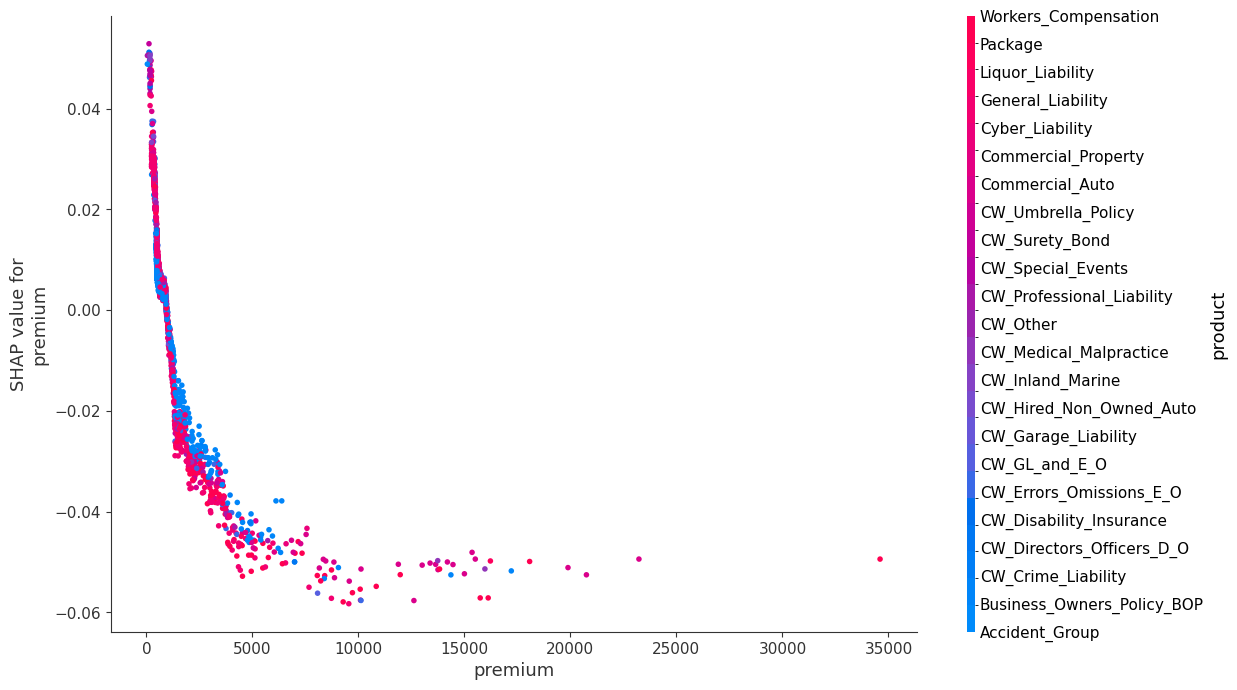

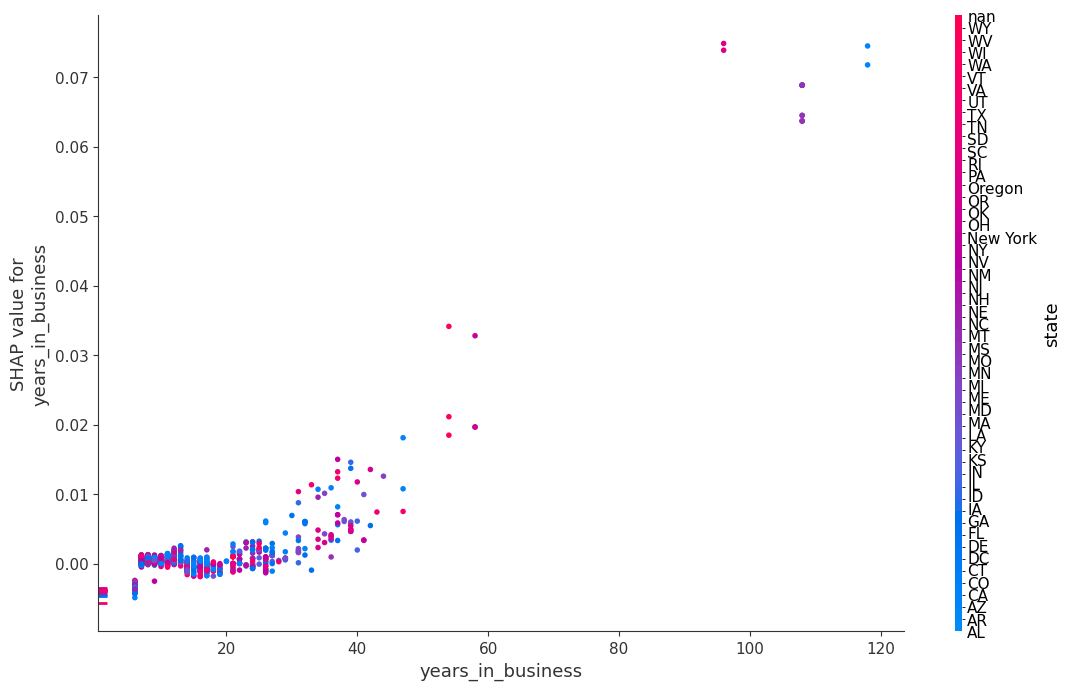

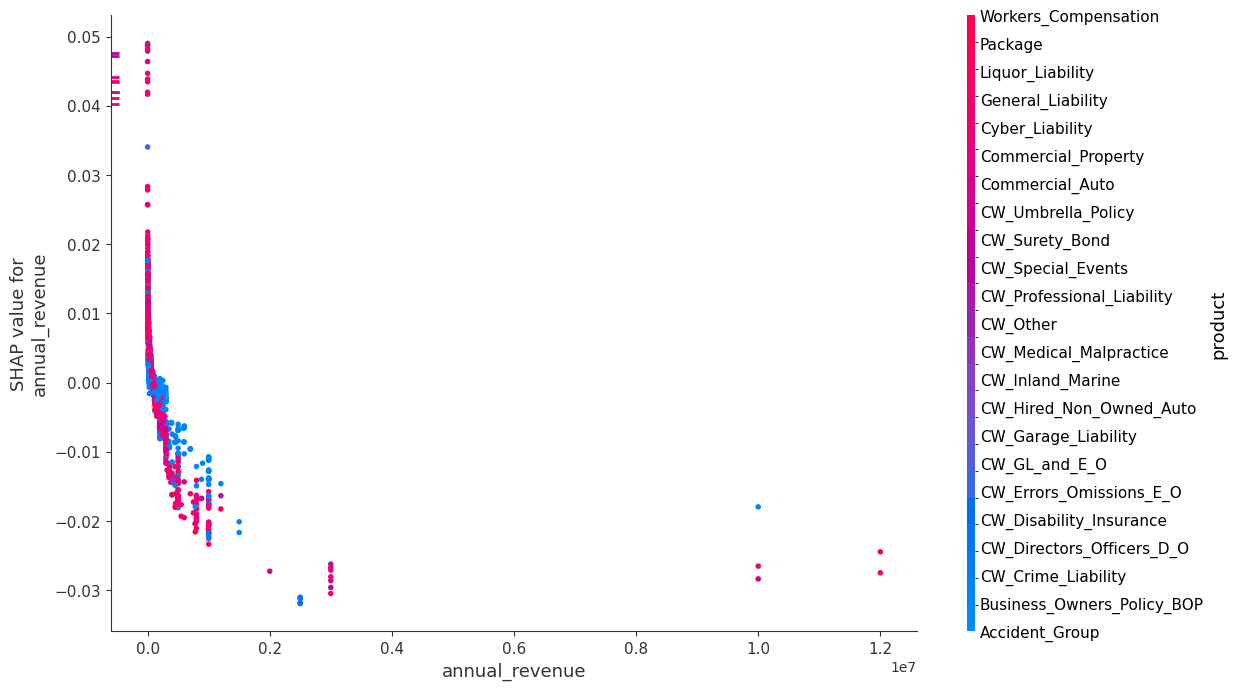

In [35]:
top_pars = ['premium', 'years_in_business', 'annual_revenue']

# make SHAP plots of the three most important features
for par in top_pars:
    fig, ax = plt.subplots(figsize=(13, 8))
    shap.dependence_plot(par, shap_values.values, X_val, ax=ax)

In this Shap plots it is possible to observe the elasticity relation with the price (premium) and also the negative relation of the annual revenue with the conversion probbability. In the other hand, it is possible to observe that for older companies there is a higher convertion probability.

Let observe an example of the elasticity curve of a product for the same person:

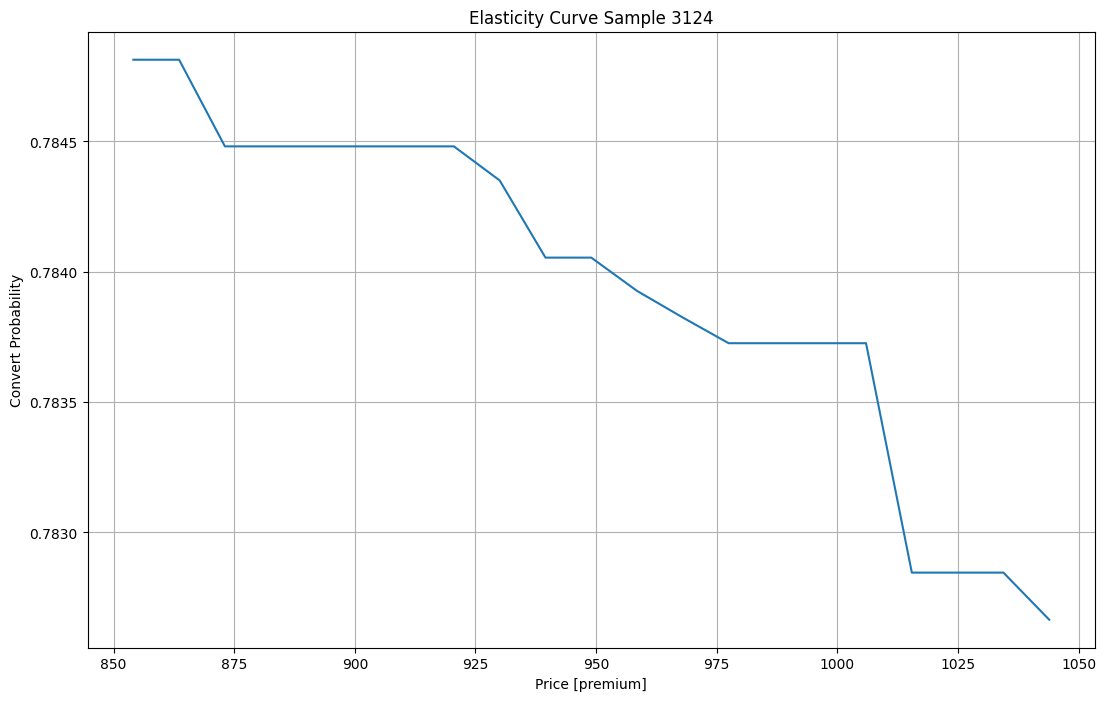

In [36]:
sample = X_val.sample(1)
premium = sample['premium'].iloc[0]
elasticity_example = pd.concat([sample.copy() for _ in range(21)])
possible_prices = [premium * (1 + i / 100) for i in range(-10, 11, 1)]
elasticity_example['premium'] = possible_prices

convert_probabilities = model_cls.predict_proba(elasticity_example)[:, 1]
fig, ax = plt.subplots(figsize=(13, 8))

ax.plot(possible_prices, convert_probabilities)
ax.set_title(f'Elasticity Curve Sample {sample.index[0]}')
ax.set_xlabel('Price [premium]')
ax.set_ylabel('Convert Probability')
plt.grid()

## Regression baseline

First, as a baseline, let's use a model where the account value is trying to be predicted directly using a regression model. 

This model is going to be used to measure how good is our model.

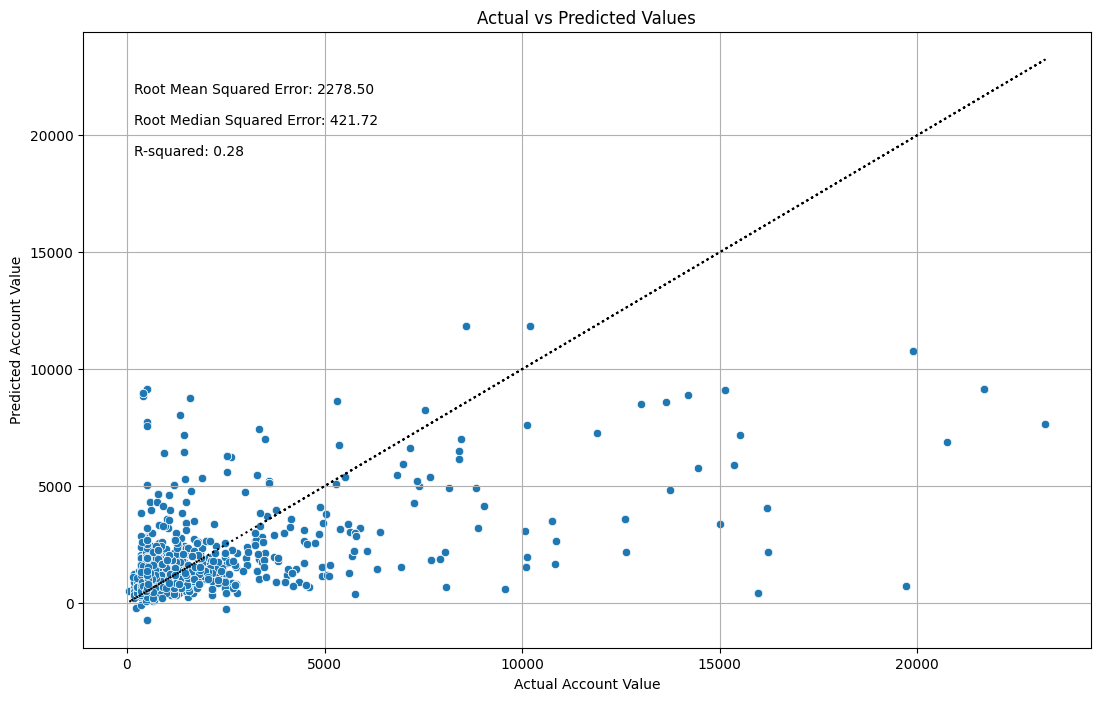

In [37]:
account_value_train_real = train.loc[train['convert'] == 1, ['account_uuid', 'premium']].groupby('account_uuid').sum().reset_index()
account_value_train_real = account_value_train_real.rename({'premium': 'account_value'}, axis=1)

train_regression = train.loc[:, [col for col in accounts_train.columns if col != 'year_established']].\
    merge(account_value_train_real, how='left', on='account_uuid').fillna(0)
X_train_regression = train_regression.loc[:, [col for col in accounts_train.columns if col not in ['account_uuid', 'year_established']]]
y_regression = train_regression['account_value']

cat_cols = identify_nominal_columns(X_train_regression)
model_regressor = CatBoostRegressor(cat_features=cat_cols)
model_regressor.fit(X_train_regression, y_regression, verbose=False)

account_value_val_real = val.loc[val['convert'] == 1, ['account_uuid', 'premium']].groupby('account_uuid').sum().reset_index()
account_value_val_real = account_value_val_real.rename({'premium': 'account_value'}, axis=1)

val_regression = val.loc[:, [col for col in accounts_train.columns if col != 'year_established']].\
    merge(account_value_val_real, how='left', on='account_uuid').fillna(0)
X_val_regression = val_regression.loc[:, [col for col in accounts_train.columns if col not in ['account_uuid', 'year_established']]]

y_true_val = val_regression['account_value']
y_pred_val = model_regressor.predict(X_val_regression)

mse = mean_squared_error(y_true_val, y_pred_val)
rmse = np.sqrt(mse)
squared_errors = (y_true_val - y_pred_val) ** 2
medse = np.median(squared_errors)
rmedse = np.sqrt(medse)
r2 = r2_score(y_true_val, y_pred_val)

fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(x=y_true_val, y=y_pred_val, ax=ax)
ax.plot(y_true_val, y_true_val, linestyle=':', color='k')
ax.set_xlabel("Actual Account Value")
ax.set_ylabel("Predicted Account Value")
ax.set_title("Actual vs Predicted Values")
plt.text(0.05, 0.9, f"Root Mean Squared Error: {rmse:.2f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f"Root Median Squared Error: {rmedse:.2f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f"R-squared: {r2:.2f}", transform=plt.gca().transAxes)
plt.grid()

### Account Value Calculation

In this section, we delve into the calculation of the account value. This calculation begins by leveraging our former classification model to predict the probability of conversion for each product offered to an individual. Subsequently, we compute the expected value by multiplying the probability of conversion by the premium (value) associated with each product. Finally, the account value is determined as the sum of the expected values for all products offered to each client. This comprehensive approach enables us to quantify the potential value of the account based on the likelihood of conversion and the associated premiums, providing valuable insights for decision-making and strategic planning.

In [38]:
convert_probabilities = model_cls.predict_proba(X_val)[:, 1]

account_value_val_real = val.loc[val['convert'] == 1, ['account_uuid', 'premium']].groupby('account_uuid').sum().reset_index()
val['expected_premium'] = val['premium'] * convert_probabilities

account_value_val_pred = val.loc[:, ['account_uuid', 'expected_premium']].groupby('account_uuid').sum().reset_index()

account_value = account_value_val_pred.merge(account_value_val_real, how='left', on='account_uuid').fillna(0)

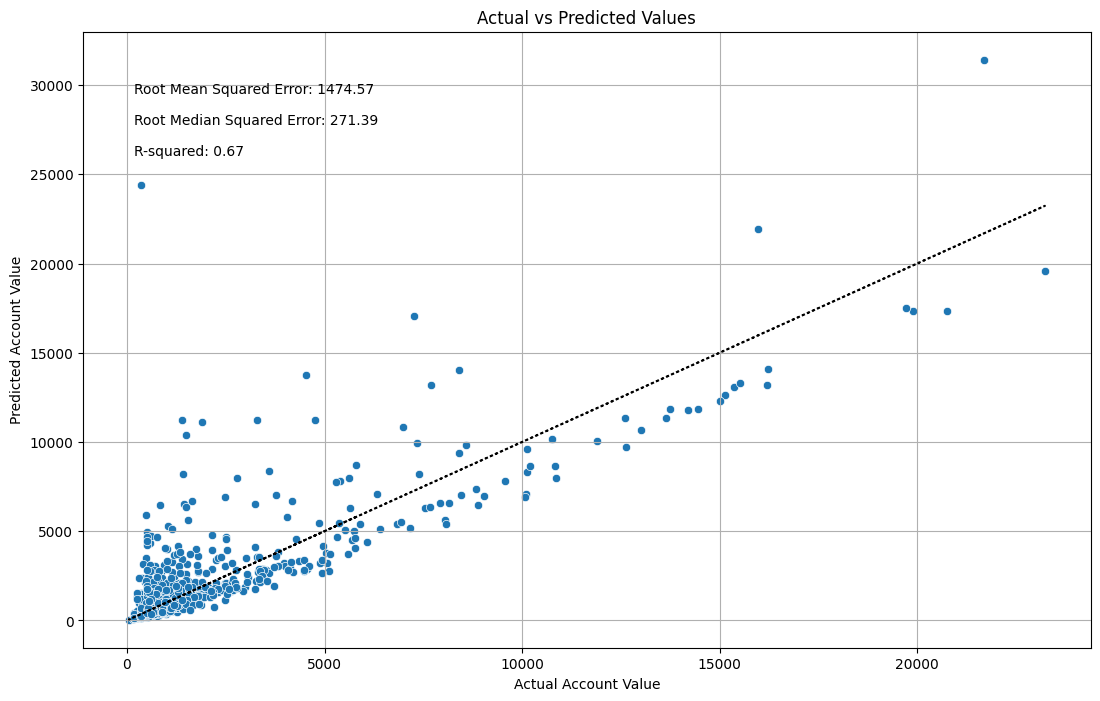

In [39]:
mse = mean_squared_error(account_value['premium'], account_value['expected_premium'])
rmse = np.sqrt(mse)
squared_errors = (account_value['premium'] - account_value['expected_premium']) ** 2
medse = np.median(squared_errors)
rmedse = np.sqrt(medse)
r2 = r2_score(account_value['premium'], account_value['expected_premium'])

fig, ax = plt.subplots(figsize=(13, 8))
sns.scatterplot(x=account_value['premium'], y=account_value['expected_premium'], ax=ax)
ax.plot(account_value['premium'], account_value['premium'], linestyle=':', color='k')
ax.set_xlabel("Actual Account Value")
ax.set_ylabel("Predicted Account Value")
ax.set_title("Actual vs Predicted Values")
plt.text(0.05, 0.9, f"Root Mean Squared Error: {rmse:.2f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.85, f"Root Median Squared Error: {rmedse:.2f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.8, f"R-squared: {r2:.2f}", transform=plt.gca().transAxes)


plt.grid()

In the previous plot and metrics, it's evident that the model performs well in predicting the account value, as indicated by an R-squared value close to 0.7. This suggests that our model captures approximately 70% of the variability in the data.

However, the RMSE value appears unfavorable, indicating poor performance. Yet, upon examining the plot, it becomes apparent that outliers are skewing this metric. These outliers represent instances where the actual account values are significantly lower than our model's predictions.

To gain a clearer insight into the model's performance across the majority of cases, we turn to the median squared error. This metric reveals that the model excels in capturing the behavior of the vast majority of cases, despite the challenges posed by outliers.

Clearly, the model is working, significantly, better than the baseline model. The R-squared value is more than 2 times the baseline, the median (and the mean) squared errors are being reduced to the half.

In [40]:
model_cls.save_model('app/static_data/conversion_model.cbm',
                     format="cbm",
                     export_parameters=None,
                     pool=None)

## Define full pipeline function

In [41]:
def preprocess_account_info(accounts: list[dict], sentence_model_path='bert-base-nli-mean-tokens') -> pd.DataFrame:
    accounts_df = pd.DataFrame(accounts)
    nominal_columns = identify_nominal_columns(accounts_df)
    nominal_columns.remove('account_uuid')

    for col in nominal_columns:
        accounts_df[col] = accounts_df[col].fillna('nan')
    
    sentence_model = SentenceTransformer(sentence_model_path, truncate_dim=5)
    encoded_data_subindustry = sentence_model.encode(accounts_df.loc[~accounts_df['subindustry'].isna(), 'subindustry'].values, 
                                                     show_progress_bar=True)
    
    accounts_df[[f'subindustry_enc_{i}' for i in range(5)]] = 0., 0., 0., 0., 0.
    accounts_df.loc[~accounts_df['subindustry'].isna(), [f'subindustry_enc_{i}' for i in range(5)]] = encoded_data_subindustry

    return accounts_df

def predict_account_value(model: CatBoostClassifier, X: list[dict]):
    X = pd.DataFrame(X)
    X_accounts = X.groupby('account_uuid')
    account_values = []
    for account, account_df in X_accounts:
        account_df = account_df.loc[:, [col for col in X.columns if col not in ['account_uuid', 'convert']]]
        premium_values = account_df['premium']
        convert_probabilities = model.predict_proba(account_df)[:, 1]
        expected_values = premium_values * convert_probabilities
        account_value = sum(expected_values, 0)
        account_values.append({
            'account_uuid': account,
            'account_value': account_value,
        })
    return account_values

In [42]:
test_prediction = pd.DataFrame(predict_account_value(model_cls, test))

In [43]:
test_prediction.to_csv('output/test_prediction.csv', index=False, float_format="%.12f", quotechar='"')

## Calling the API

In this section, I'll demonstrate how to use HTTP PUT requests to interact with APIs. Throughout this part, I'll provide clear examples and explanations to guide you through the process. We'll cover how to specify the resource to update, format the request body with new data, and handle the server's response. We'll also ensure the API's output matches the notebook output to confirm its functionality. 

In [44]:
import requests
from app.pydantic_model import Payload
from fastapi.encoders import jsonable_encoder
from typing import Union

def call_api_model(payload: Payload) -> Union[dict, None]:
    response = requests.put('http://127.0.0.1:8000/predict_account_value',
                            json=payload,
                            headers={'accept': 'application/json', 'Content-Type': 'application/json'})

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        return response
    else:
        print("Error:", response.text)
        return None

In [45]:
accounts_test_api = pd.read_csv('data/accounts_test.csv')
accounts_test_api = accounts_test_api.replace({np.nan: None})
accounts_test_api = accounts_test_api.to_dict(orient='records')

quotes_test_api = pd.read_csv('data/quotes_test.csv')
quotes_test_api = quotes_test_api.replace({np.nan: None})
quotes_test_api = quotes_test_api.to_dict(orient='records')

payload = {
    'accounts': accounts_test_api,
    'quotes': quotes_test_api,
}

In [46]:
response = call_api_model(payload)

In [47]:
response_df_api = pd.DataFrame(response.json())
response_df = pd.read_csv('output/test_prediction.csv')

In [48]:
response_df_api = response_df_api.rename({'account_value': 'account_value_api'}, axis=1)
response_df = response_df.rename({'account_value': 'account_value_notebook'}, axis=1)

response_comparisson = response_df_api.merge(response_df, how='inner', on='account_uuid')

In [49]:
assert len(response_comparisson) == len(response_df)
assert all((response_comparisson['account_value_api'] - response_comparisson['account_value_notebook']) < 1e6)